In [123]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [103]:
filepath = 'data/job_postings.csv'
df=pd.read_csv(filepath)

#convert date columns to date time
df['listed_time'] = pd.to_datetime(df['listed_time'], unit='ms')

#convert company ID to an int, convert NaN to NaN
df['company_id'] = pd.to_numeric(df['company_id'], errors='coerce').astype('Int64')

#Pre-process and convert NaNs in company ID to -1
df['company_id'] = df['company_id'].fillna(-1)

#display df
df

,job_id,company_id,title,description,max_salary,med_salary,min_salary,pay_period,formatted_work_type,location,...,closed_time,formatted_experience_level,skills_desc,listed_time,posting_domain,sponsored,work_type,currency,compensation_type,scraped
0,3757940104,553718,Hearing Care Provider,Overview\n\nHearingLife is a national hearing ...,NaN,5250.00,NaN,MONTHLY,Full-time,"Little River, SC",...,NaN,Entry level,NaN,2023-11-04 09:26:40,careers-demant.icims.com,0,FULL_TIME,USD,BASE_SALARY,1699138101
1,3757940025,2192142,Shipping & Receiving Associate 2nd shift (Beav...,Metalcraft of Mayville\nMetalcraft of Mayville...,NaN,NaN,NaN,NaN,Full-time,"Beaver Dam, WI",...,NaN,NaN,NaN,2023-11-04 06:40:00,www.click2apply.net,0,FULL_TIME,NaN,NaN,1699085420
2,3757938019,474443,"Manager, Engineering",\nThe TSUBAKI name is synonymous with excellen...,NaN,NaN,NaN,NaN,Full-time,"Bessemer, AL",...,NaN,NaN,Bachelor's Degree in Mechanical Engineering pr...,2023-11-04 06:40:00,www.click2apply.net,0,FULL_TIME,NaN,NaN,1699085644
3,3757938018,18213359,Cook,descriptionTitle\n\n Looking for a great oppor...,NaN,22.27,NaN,HOURLY,Full-time,"Aliso Viejo, CA",...,NaN,Entry level,NaN,2023-11-04 06:40:00,jobs.apploi.com,0,FULL_TIME,USD,BASE_SALARY,1699087461
4,3757937095,437225,Principal Cloud Security Architect (Remote),"Job Summary\nAt iHerb, we are on a mission to ...",275834.0,NaN,205956.0,YEARLY,Full-time,United States,...,NaN,Mid-Senior level,NaN,2023-11-04 09:26:40,careers.iherb.com,0,FULL_TIME,USD,BASE_SALARY,1699085346
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33241,133114754,77766802,Sales Manager,Are you a dynamic and creative marketing profe...,NaN,NaN,NaN,NaN,Full-time,"Santa Clarita, CA",...,NaN,NaN,NaN,2023-08-23 22:33:20,NaN,0,FULL_TIME,NaN,NaN,1
33242,108965123,-1,Office Administrative Assistant,"A fast-fashion wholesaler, is looking for a fu...",NaN,NaN,NaN,NaN,Full-time,"New York, NY",...,NaN,NaN,NaN,2023-11-03 19:33:20,NaN,0,FULL_TIME,NaN,NaN,1699044401
33243,102339515,52132271,Franchise Owner,DuctVentz is a dryer and A/C – heat vent clean...,NaN,NaN,NaN,NaN,Full-time,Greater Boston,...,NaN,NaN,NaN,2023-11-03 22:20:00,NaN,0,FULL_TIME,NaN,NaN,1699063495
33244,85008768,-1,Licensed Insurance Agent,While many industries were hurt by the last fe...,52000.0,NaN,45760.0,YEARLY,Full-time,"Chico, CA",...,NaN,NaN,NaN,2023-08-23 00:20:00,NaN,1,FULL_TIME,USD,BASE_SALARY,1


In [104]:
df.isnull().sum()

job_id                            0
company_id                        0
title                             0
description                       1
max_salary                    22135
med_salary                    31005
min_salary                    22135
pay_period                    19894
formatted_work_type               0
location                          0
applies                       17008
original_listed_time              0
remote_allowed                28444
views                          7360
job_posting_url                   0
application_url               12250
application_type                  0
expiry                            0
closed_time                   32074
formatted_experience_level     9181
skills_desc                   32909
listed_time                       0
posting_domain                13558
sponsored                         0
work_type                         0
currency                      19894
compensation_type             19894
scraped                     

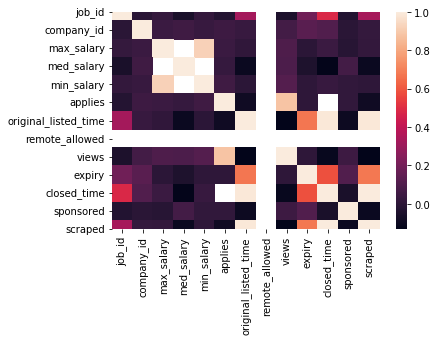

In [124]:
sns.heatmap(df.corr())

In [105]:
filepathforcompany = 'data/company_details/companies.csv'
df2 = pd.read_csv(filepathforcompany)
df2

,company_id,name,description,company_size,state,country,city,zip_code,address,url
0,1009,IBM,"At IBM, we do more than work. We create. We cr...",7.0,NY,US,"Armonk, New York",10504,International Business Machines Corp.,https://www.linkedin.com/company/ibm
1,1016,GE HealthCare,Every day millions of people feel the impact o...,7.0,0,US,Chicago,0,-,https://www.linkedin.com/company/gehealthcare
2,1021,GE Power,"GE Power, part of GE Vernova, is a world energ...",7.0,NY,US,Schenectady,12345,1 River Road,https://www.linkedin.com/company/gepower
3,1025,Hewlett Packard Enterprise,Official LinkedIn of Hewlett Packard Enterpris...,7.0,Texas,US,Houston,77389,1701 E Mossy Oaks Rd Spring,https://www.linkedin.com/company/hewlett-packa...
4,1028,Oracle,We’re a cloud technology company that provides...,7.0,Texas,US,Austin,78741,2300 Oracle Way,https://www.linkedin.com/company/oracle
...,...,...,...,...,...,...,...,...,...,...
11356,3700144594,BYREDO,"""Beauty can be many things to many people. Our...",3.0,0,0,0,0,0,https://www.linkedin.com/company/byredo
11357,3700144710,"Pros2Plan, a division of Spinnaker SCA","Pros2Plan, a division of Spinnaker Services L...",2.0,CO,US,Boulder,80303,0,https://www.linkedin.com/company/pros2plan
11358,3700147810,Ascendo Resources,Ascendo Resources is a certified minority owne...,3.0,FL,US,Coral Gables,33134,2 Alhambra Plaza,https://www.linkedin.com/company/ascendoresources
11359,3700150295,The Crox Group,"The Crox Group, Head Quartered in Chicago, wit...",2.0,Illinois,US,Lincolnwood,60712,6818 N Lincoln Ave,https://www.linkedin.com/company/the-crox-group


In [115]:
#left join df with company info on company_id
result_df = pd.merge(df, df2, on='company_id', how='left')

#replace the -1s with NaN in company_id
result_df['company_id'] = result_df['company_id'].replace(-1, np.nan)

#show the new df
result_df

,job_id,company_id,title,description_x,max_salary,med_salary,min_salary,pay_period,formatted_work_type,location,...,scraped,name,description_y,company_size,state,country,city,zip_code,address,url
0,3757940104,553718,Hearing Care Provider,Overview\n\nHearingLife is a national hearing ...,NaN,5250.00,NaN,MONTHLY,Full-time,"Little River, SC",...,1699138101,HearingLife,HearingLife is a national hearing care company...,5.0,New Jersey,US,Somerset,08873,580 Howard Avenue,https://www.linkedin.com/company/hearing-life
1,3757940025,2192142,Shipping & Receiving Associate 2nd shift (Beav...,Metalcraft of Mayville\nMetalcraft of Mayville...,NaN,NaN,NaN,NaN,Full-time,"Beaver Dam, WI",...,1699085420,"Metalcraft of Mayville, Inc.","Headquartered in Mayville, Wisconsin, Metalcra...",4.0,WI,US,Mayville,53050,1000 Metalcraft Drive,https://www.linkedin.com/company/metalcraft-of...
2,3757938019,474443,"Manager, Engineering",\nThe TSUBAKI name is synonymous with excellen...,NaN,NaN,NaN,NaN,Full-time,"Bessemer, AL",...,1699085644,"U.S. Tsubaki Power Transmission, LLC","U.S. Tsubaki Power Transmission, LLC is a subs...",4.0,Illinois,US,Wheeling,60090,301E Marquardt Drive,https://www.linkedin.com/company/u.s.-tsubaki-...
3,3757938018,18213359,Cook,descriptionTitle\n\n Looking for a great oppor...,NaN,22.27,NaN,HOURLY,Full-time,"Aliso Viejo, CA",...,1699087461,Episcopal Communities & Services,Episcopal Communities & Services (ECS) has bec...,4.0,California,US,Altadena,91001,2212 El Molino Ave,https://www.linkedin.com/company/episcopal-com...
4,3757937095,437225,Principal Cloud Security Architect (Remote),"Job Summary\nAt iHerb, we are on a mission to ...",275834.0,NaN,205956.0,YEARLY,Full-time,United States,...,1699085346,"iHerb, LLC",iHerb is on a mission to make health and welln...,5.0,California,US,Irvine,92618,17400 Laguna Canyon Rd,https://www.linkedin.com/company/iherb
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33241,133114754,77766802,Sales Manager,Are you a dynamic and creative marketing profe...,NaN,NaN,NaN,NaN,Full-time,"Santa Clarita, CA",...,1,CargoLogin.,CargoLogin is a freight and logistics company ...,1.0,California,US,Santa Clarita,28358,Constellation Rd,https://www.linkedin.com/company/cargologinllc
33242,108965123,<NA>,Office Administrative Assistant,"A fast-fashion wholesaler, is looking for a fu...",NaN,NaN,NaN,NaN,Full-time,"New York, NY",...,1699044401,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
33243,102339515,52132271,Franchise Owner,DuctVentz is a dryer and A/C – heat vent clean...,NaN,NaN,NaN,NaN,Full-time,Greater Boston,...,1699063495,DryerVentz - DuctVentz,"DryerVentz operates, manages and markets Dryer...",1.0,0,US,New York,0,0,https://www.linkedin.com/company/dryerventz-du...
33244,85008768,<NA>,Licensed Insurance Agent,While many industries were hurt by the last fe...,52000.0,NaN,45760.0,YEARLY,Full-time,"Chico, CA",...,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [116]:
#This cell looks at record count for job titles and attempts to clean

result_df['Title_Count'] = result_df.groupby('title')['title'].transform('count')

title_result_df_sorted = result_df.sort_values(by='Title_Count', ascending=False)

# Filter rows for City Lifestyle postings
filtered_result_df = title_result_df_sorted[title_result_df_sorted['url'] != 'https://www.linkedin.com/company/citylifestyle']

# Display the filtered DataFrame
print(filtered_result_df)


           job_id  company_id  \
31390  3693049649     6591488   
20609  3700550327    73013724   
179    3757919585    73013724   
16239  3749347137      444704   
158    3757921570    73013724   
...           ...         ...   
13698  3754508188       53193   
13697  3754508213        5471   
13695  3754508225     1258341   
13694  3754508252        5107   
33245     3958427      630152   

                                                   title  \
31390                                      Sales Manager   
20609                                      Sales Manager   
179                                        Sales Manager   
16239                                      Sales Manager   
158                                        Sales Manager   
...                                                  ...   
13698                      Inventory Control Team Leader   
13697  Reliability Maintenance Engineering Internship...   
13695  Fusion Global Academy Virtual Teacher/Mentor -...   
136

In [117]:
df['title'].value_counts()


Sales Director [Owner/Operator]                        120
Sales Manager                                           99
Project Manager                                         97
Customer Service Representative                         85
Senior Accountant                                       83
                                                      ... 
Manager for Adjuvant, CMC Operations                     1
Outside Sales Associate - Union City, CA                 1
Lead Software Engineer, Full Stack                       1
Store Associate - Wilmington, NC (Oleander Dr)(GRM)      1
Marketing Communications Associate                       1
Name: title, Length: 22404, dtype: int64

Text(0.5, 1.0, 'Most in-demand jobs posted on LinkedIn')

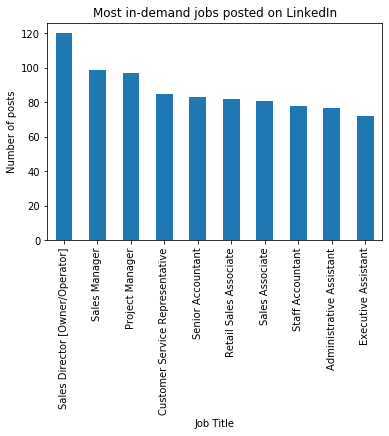

In [119]:
#Plot a bar plot of the top 10 job titles posted on LinkedIn
fig = result_df.groupby('title')['title'].count().sort_values(ascending=False).head(10).plot.bar()
plt.xlabel('Job Title')
plt.ylabel('Number of posts')
plt.title("Most in-demand jobs posted on LinkedIn")


In [110]:
#this cell groups by location and returns the mean salary for each location

average_values = df.groupby('location')['med_salary'].mean().reset_index()

result_df = df.groupby('location')['med_salary'].agg(['mean', 'count']).reset_index()

result_df.columns = ['Location', 'Mean', 'Salary Count']

In [111]:
#this cell sorts by the avg med salary and adds a column that keeps track of how many jobs offer that avg salary

average_values_sorted = average_values.sort_values(by='med_salary', ascending=False)

result_df_sorted = result_df.sort_values(by='Mean', ascending=False)

# Assuming result_df_sorted is the DataFrame you want to modify
result_df_filtered = result_df_sorted.loc[result_df_sorted['Salary Count'] > 1]

# Display the sorted result
print(average_values_sorted)

# Display the modified DataFrame
print(result_df_filtered)

                    location  med_salary
4106            Thompson, CT    785358.0
2665        Midwest City, OK    440000.0
1516             Garland, TX    400000.0
3643  San Francisco Bay Area    366673.0
3171            Palm Bay, FL    300000.0
...                      ...         ...
4615             Zachary, LA         NaN
4616          Zanesville, OH         NaN
4618            Zellwood, FL         NaN
4619          Zionsville, IN         NaN
4620              Zwolle, LA         NaN

[4621 rows x 2 columns]
                     Location           Mean  Salary Count
3643   San Francisco Bay Area  366673.000000             3
3171             Palm Bay, FL  300000.000000             2
3583           Round Rock, TX  200398.380000             3
3273         Phoenixville, PA  150591.000000             2
2927  New York, United States  144438.769231            13
...                       ...            ...           ...
1675    Greater Yuma, AZ Area      13.850000             2
2459       

Text(0.5, 1.0, 'Location of top mean salaries posted on LinkedIn')

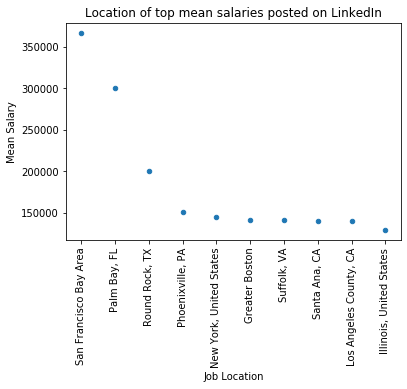

In [121]:
# Plot a scatter plot of the locations with the 10 highest mean salary
result_df_filtered.head(10).plot.scatter(x='Location', y='Mean')
plt.xticks(rotation=90)
plt.xlabel("Job Location")
plt.ylabel("Mean Salary")
plt.title("Location of top mean salaries posted on LinkedIn")